In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
!pip install scipy
#!pip install pyodbc

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from scipy.stats import bootstrap
import scipy.stats as stats
#pd.options.display.float_format = '{:,.0f}'.format

In [4]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [5]:
#dfreco = pd.read_parquet("recommendations.parquet")
#dfgame = pd.read_csv("games.csv")
#dfuser = pd.read_csv("users.csv")
#dfmeta = pd.read_json('games_metadata.json', lines=False)

In [8]:
def create_box_and_hist(data, column):
    fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(4, 4), gridspec_kw={"height_ratios": (.85, .15)})
    ax_hist.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax_hist.set_title('Histogram')
    ax_hist.set_xlabel(f'# {column}')
    ax_box.boxplot(data[column], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='orange'))
    ax_box.set_xticks([])
    ax_box.set_yticks([])
    plt.tight_layout()
    plt.show()

def boot(data, column, stat, stat_label):
    rnd = 42
    res = bootstrap((data[column].values,), stat, confidence_level=0.9,
                    random_state=rnd, batch=1)
    fig, ax = plt.subplots()
    ax.hist(res.bootstrap_distribution, bins=25)
    ax.set_title('Bootstrap Distribution')
    ax.set_xlabel(stat_label)
    ax.set_ylabel('frequency')
    plt.show()
    return res

In [3]:
# load our users
dfuser = pd.read_csv("users.csv")
dfuser.set_index('user_id')
dfuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB


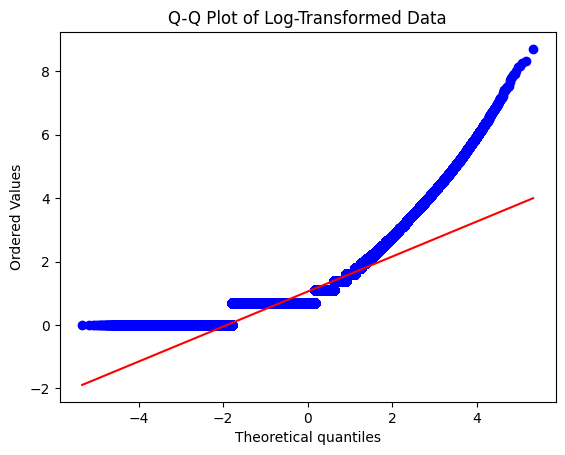

In [46]:
stats.probplot(np.log(dfuser.reviews.values+1), plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')
plt.show()

In [45]:
from scipy.stats import shapiro

stat, p_value = shapiro(np.log(dfuser.reviews.values+1))
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

Shapiro-Wilk Test Statistic: 0.7854964069171608
p-value: 1.3774705874350512e-186


In [29]:
from scipy.stats import kstest

# Define the log-normal CDF function with the estimated parameters
shape, loc, scale = stats.lognorm.fit(dfuser.reviews.values+1, floc=0)
cdf = lambda x: stats.lognorm.cdf(x, shape, loc, scale)

stat, p_value = kstest(dfuser.reviews.values+1, cdf)
print('Kolmogorov-Smirnov Test Statistic:', stat)
print('p-value:', p_value)

Kolmogorov-Smirnov Test Statistic: 0.2848561444213167
p-value: 0.0


In [30]:
from scipy.stats import anderson

result = anderson(np.log(dfuser.reviews.values+1), dist='norm')
print('Anderson-Darling Test Statistic:', result.statistic)
print('Critical Values:', result.critical_values)

Anderson-Darling Test Statistic: 1196191.764160661
Critical Values: [0.576 0.656 0.787 0.918 1.092]


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, chisquare

data = np.log(dfuser[dfuser.reviews>0].reviews.values)
# Assuming 'data' is your dataset
#data = np.random.lognormal(mean=0, sigma=1, size=1000)  # Example data

# Step 1: Calculate observed frequencies
observed_freq, bins = np.histogram(data, bins='auto', density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Step 2: Calculate expected frequencies based on log-normal distribution
shape, loc, scale = lognorm.fit(data, floc=0)
expected_freq = lognorm.pdf(bin_centers, shape, loc, scale) * np.diff(bins)

# Step 3: Scale expected frequencies to match the sum of observed frequencies
expected_freq_scaled = expected_freq * sum(observed_freq) / sum(expected_freq)

# Step 4: Perform the chi-square test
chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq_scaled)

print('Chi-Square Test Statistic:', chi2_stat)
print('p-value:', p_value)

# Optional: Plot histogram and PDF
plt.hist(data, bins=bins, density=True, alpha=0.6, color='g', label='Observed Data')
plt.plot(bin_centers, expected_freq, 'r--', linewidth=2, label='Expected Log-normal PDF')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram and Expected Log-normal PDF')
plt.show()


FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'lognorm' requires that 0.0 < (x - loc)/scale  < inf for each x in `data`.

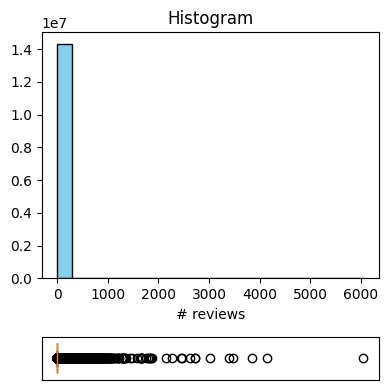

In [8]:
create_box_and_hist(dfuser, 'reviews')

In [5]:
df_high_reviews = dfuser[dfuser.reviews >= np.percentile(dfuser.reviews.values, 99)]

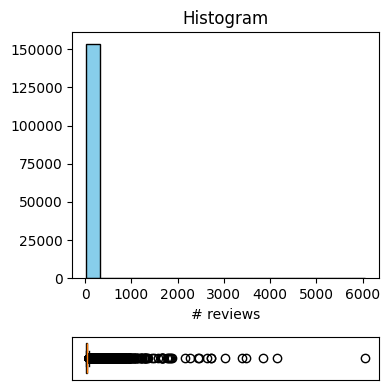

In [9]:
create_box_and_hist(df_high_reviews, 'reviews')

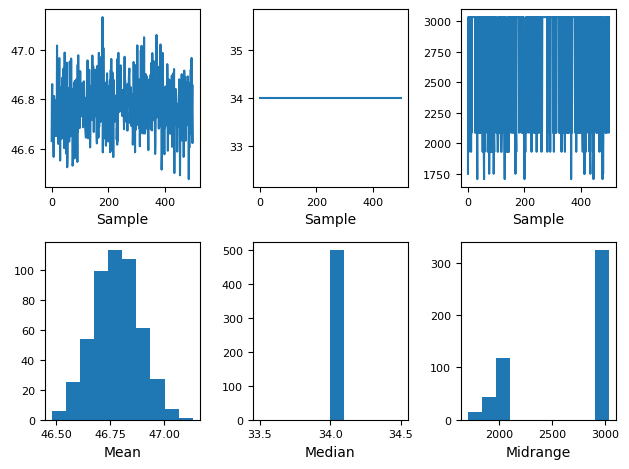

In [12]:
# plot users bootstrap 
pd.plotting.bootstrap_plot(df_high_reviews.drop('products', axis=1).reviews, size=100000)
plt.show()

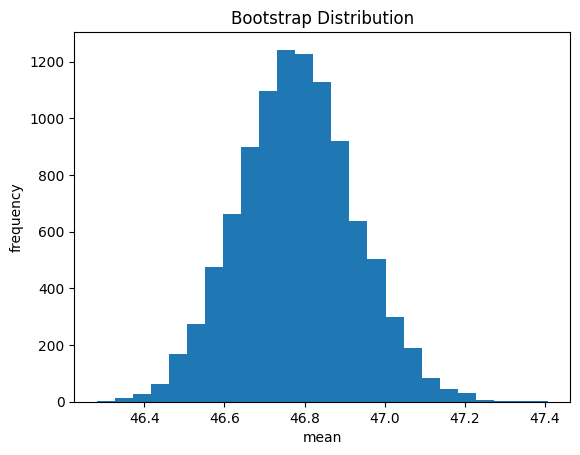

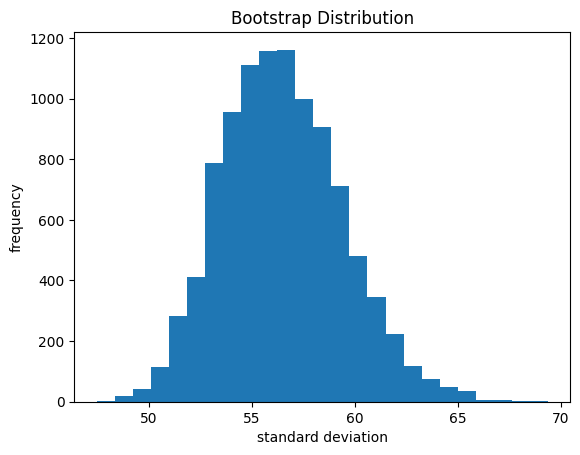

In [7]:
mean_stats = boot(df_high_reviews, 'reviews', np.mean, 'mean')
std_stats = boot(df_high_reviews, 'reviews', np.std, 'standard deviation')

In [9]:
[mean_stats.confidence_interval.low, mean_stats.bootstrap_distribution.mean(), mean_stats.confidence_interval.high]

[46.55082755133897, 46.781159970424675, 47.03089649715139]

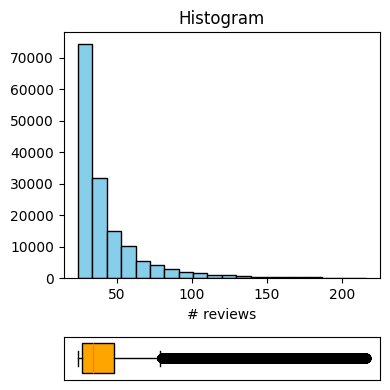

In [20]:
high = np.percentile(df_high_reviews.reviews.values, 99)
low = np.percentile(df_high_reviews.reviews.values, 1)

df_users_clean = df_high_reviews[(df_high_reviews.reviews <= high)&(df_high_reviews.reviews >= low)]
create_box_and_hist(df_users_clean, 'reviews')



In [32]:
mean_stats.standard_error

0.14496763134183513

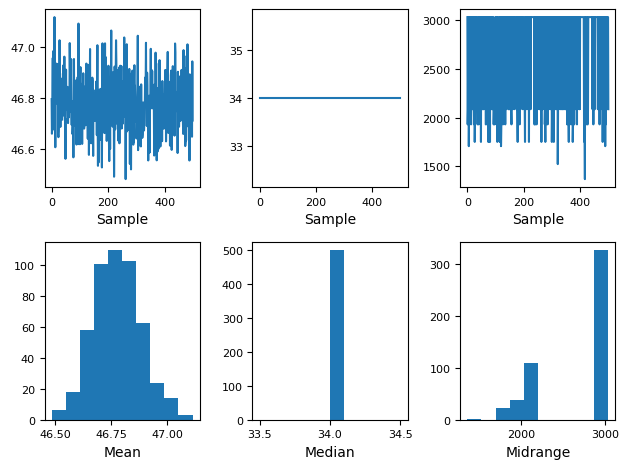

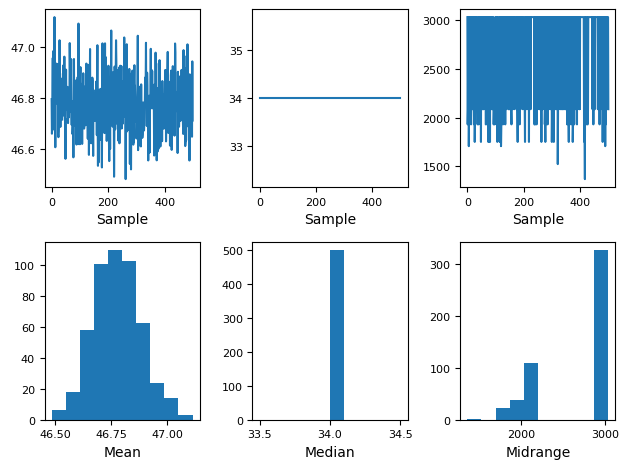

In [10]:
# plot users bootstrap 
pd.plotting.bootstrap_plot(df_high_reviews.drop('products', axis=1).reviews, size=100000)

In [86]:
np.percentile(dfuser.reviews,99)

24.0

<Axes: >

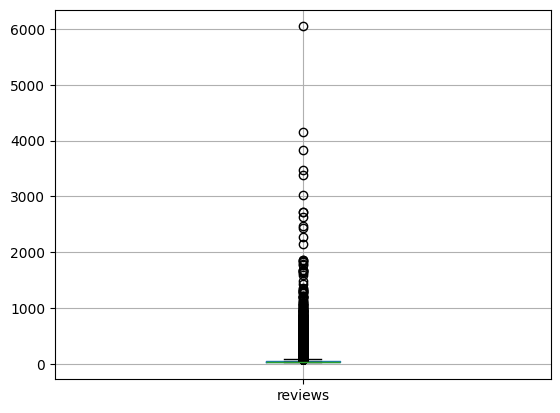

In [98]:
big_users = dfuser[dfuser.reviews>=24]
big_users.boxplot('reviews')

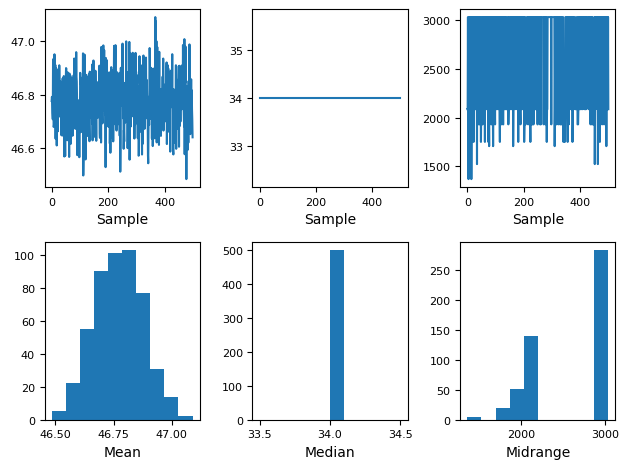

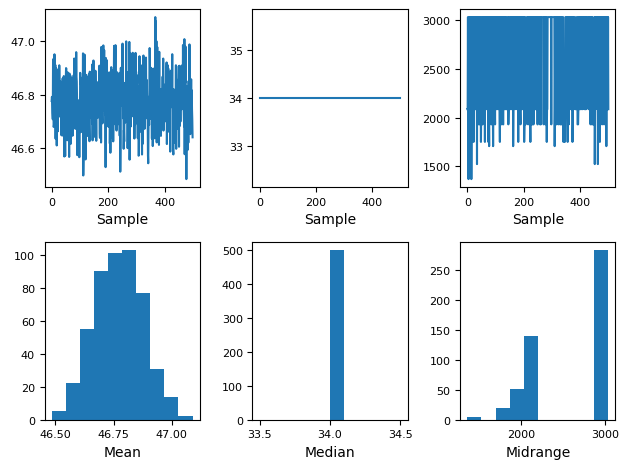

In [100]:
pd.plotting.bootstrap_plot(big_users.reviews, size=100000)

In [45]:
dfuser.std_reviews.mean()

-3.811265444589584e-17

<Axes: >

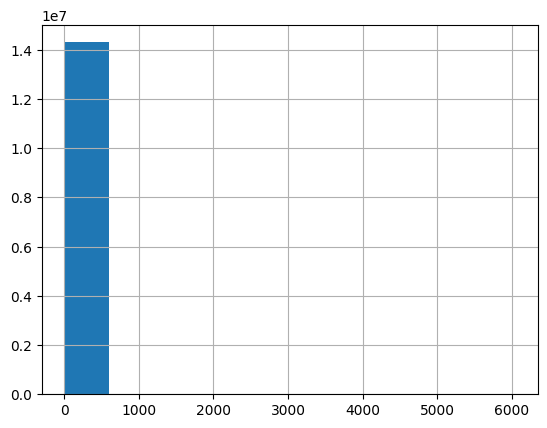

In [85]:
dfuser.reviews.hist()

<Axes: >

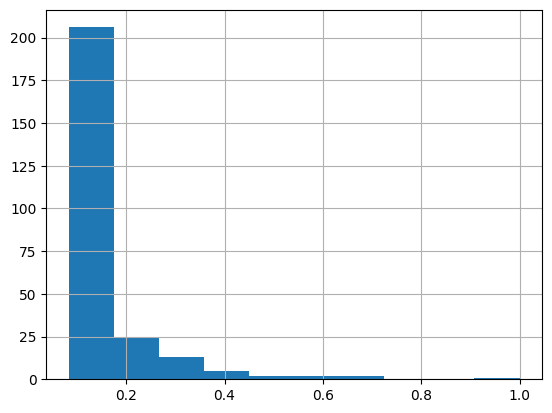

In [38]:
limited = dfuser[dfuser.reviews > 500]

limited.norm_reviews.hist()


In [5]:
(1.5*dfuser.reviews.quantile(0.95)-dfuser.reviews.quantile(0.10))+dfuser.reviews.quantile(0.95)

21.5

In [20]:
len(dfuser[dfuser.reviews > 21.5])

180284

In [25]:
scaler = StandardScaler()
hu = dfuser[dfuser.reviews > 21.5][['reviews']].values
#scaler.fit_transform(hu)


In [26]:
dfuser['log_reviews'] = np.log10(dfuser.reviews+1)

In [27]:

scaler = StandardScaler()
hu = dfuser[['reviews']].values
dfuser['scaled_reviews'] = scaler.fit_transform(hu)

upper_range = (1.5*dfuser.scaled_reviews.quantile(0.90)-dfuser.scaled_reviews.quantile(0.10))+dfuser.scaled_reviews.quantile(0.90)

high_reviews = dfuser[dfuser.scaled_reviews > upper_range]

high_reviews

,user_id,products,reviews,norm_reviews,std_reviews,log_reviews,scaled_reviews
18,11300174,210,17,0.002812,1.768188,1.255273,1.768188
22,11543905,1334,17,0.002812,1.768188,1.255273,1.768188
45,4616950,702,36,0.005955,4.146928,1.568202,4.146929
57,5717215,138,14,0.002316,1.392598,1.176091,1.392598
92,9021133,1227,22,0.003639,2.394172,1.361728,2.394172
...,...,...,...,...,...,...,...
14304332,3939312,53,26,0.004301,2.894960,1.431364,2.894960
14304388,3954523,137,46,0.007610,5.398897,1.672098,5.398897
14304690,4065740,201,16,0.002647,1.642991,1.230449,1.642991
14304876,4156581,367,80,0.013234,9.655590,1.908485,9.655591


In [ ]:
#Let's cluster users on number of reviews performed and see if we see a definite pattern of users
scaler = StandardScaler()
X = scaler.fit_transform(dfuser[['reviews']].sample(n=10000, random_state=1).values)
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,114,15,16]

for n in n_clusters:
    cmod = MiniBatchKMeans(n_clusters=n, random_state=42)
    labels = cmod.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, labels)
    print(
        "For n_clusters =",
        n,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, labels)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n + 1) * 10])
    
    y_lower = 10
    for i in range(n):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / n)
    ax2.scatter(
        X[:, 0], X[:, 0], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = cmod.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 0],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[0], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(dfuser[['reviews']].values)
cmod = MiniBatchKMeans(n_clusters=2, random_state=42)
labels = cmod.fit_predict(X)



In [ ]:
dfuser['anomaly'] = labels

dfuser[~(dfuser['products'] < dfuser['reviews']) & (dfuser['anomaly']==1)]

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()